In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


### Prepare Training Data

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import zipfile

In [3]:
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip") as z:
    z.extractall(".")
import zipfile
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip") as z:
    z.extractall(".")

In [4]:
train_path="/kaggle/working/train/"
train_files=os.listdir(train_path)

In [5]:
categories=[]
for filename in train_files:
    categories.append(filename.split(".")[0])
df=pd.DataFrame({
    'filename':train_files,
    'category':categories
})

In [6]:
df.head()

,filename,category
0,dog.6127.jpg,dog
1,cat.2258.jpg,cat
2,dog.125.jpg,dog
3,cat.349.jpg,cat
4,dog.973.jpg,dog


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import preprocessing 

#### Some exemples

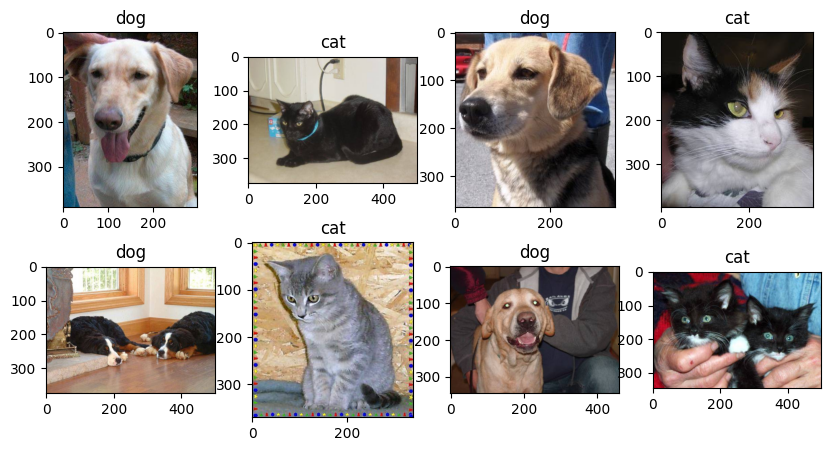

In [8]:
fig=plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    img=plt.imread(os.path.join(train_path, train_files[i]))
    plt.title(df['category'][i])
    plt.imshow(img)

### Training Generator

In [9]:
train_generator=keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2
)

In [10]:
train_data=train_generator.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='filename',
    y_col='category',
    subset='training',
    class_mode='categorical',
    target_size=(258,258),
    batch_size=32,
)

Found 20000 validated image filenames belonging to 2 classes.


In [11]:
val_data=train_generator.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='filename',
    y_col='category',
    target_size=(258,258),
    subset='validation',
    batch_size=32,
)

Found 5000 validated image filenames belonging to 2 classes.


### Model

In [12]:
from keras import layers
from keras.callbacks import EarlyStopping
earlystop=EarlyStopping(patience=10)

In [13]:
model=tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, activation='relu', 
                  input_shape=(258,258,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=3, strides=1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2, strides=1),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=2, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=3, strides=1),
    
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=2, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=3, strides=1),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.BatchNormalization(),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    layers.Dense(2, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,173,794 (8.29 MB)

 Trainable params: 2,171,362 (8.28 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [15]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [16]:
history = model.fit(
    train_data, 
    validation_data=val_data,
    epochs=20,
    batch_size=32,
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726992054.174286      68 service.cc:145] XLA service 0x790bc8008ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726992054.174368      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/625 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.4818 - loss: 1.0639

I0000 00:00:1726992063.984722      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - accuracy: 0.5530 - loss: 0.8588 - val_accuracy: 0.6376 - val_loss: 0.6463
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.6961 - loss: 0.5880 - val_accuracy: 0.6318 - val_loss: 0.6349
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.7733 - loss: 0.4969 - val_accuracy: 0.5408 - val_loss: 1.0762
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - accuracy: 0.8090 - loss: 0.4294 - val_accuracy: 0.8054 - val_loss: 0.4219
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.8504 - loss: 0.3460 - val_accuracy: 0.8634 - val_loss: 0.3082
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - accuracy: 0.8822 - loss: 0.2828 - val_accuracy: 0.8310 - val_loss: 0.3810
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9022 - loss: 0.2384 - val_accuracy: 0.8136 - val_loss: 0.4218
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.9146 - loss: 0.2140 - val_accurac

In [17]:
history_df=pd.DataFrame(history.history)

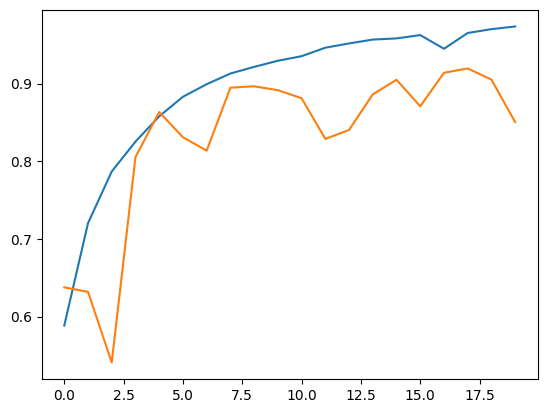

In [18]:
plt.plot(history_df[['accuracy', 'val_accuracy']])

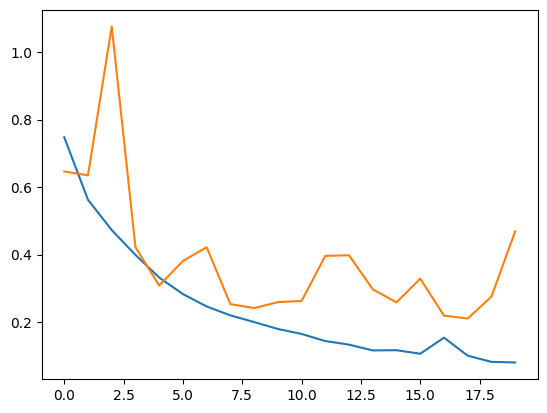

In [19]:
plt.plot(history_df[['loss', 'val_loss']])